## NODO QUERY GENERATOR con LANGGRAPH

---------

### TODO:
1. la salida de mi subgrafo debe decir si OK o si no, pensarlo 

----------

El objetivo es crear un flujo con Langgraph:
- START : simulando ser el Nodo **Generador de Contexto**
- NODO : contiene el LLM generador de consultas SQL
    - Tool del NODO : encargado de verificar sintaxis y que sea una query read only
- END : Devuelvo la query generada de manera correcta ó comunico que no se ha podido (si itero mas de N veces en la tool)

### LIBRERIAS

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI

import os
import re
from dotenv import load_dotenv 
from typing import Annotated, Optional, List, Dict, Any, NotRequired
from typing_extensions import TypedDict

import sqlglot
from sqlglot.errors import ParseError

### SETTINGS

In [2]:
load_dotenv()       #Cargo las variables del archivo .env

API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
API_VERSION = os.getenv("OPENAI_API_VERSION")
MODELO = "gpt-4o"

### 1. Creación del **StateGraph**


Hay 2 STATEs:
- State Global: `State` que es el del grafo principal
- State Local: `QueryGeneratorState` que es el que utiliza mi subgrafo, y que no ensucia al global



### STATE Local : QueryGeneratorState
El state es el contenedor de memoria compartido que fluye entre los nodos.

Cada nodo recibe el state, lee lo que necesita, devuelve un delta (solo las claves que quiere actualizar) y LangGraph fusiona ese delta con el state existente usando las “reglas de actualización” que tú definas (por clave). Esto te da un flujo determinista y transparente.

In [3]:
# Reducer "sum" para contadores: si un nodo devuelve attempt=1,
# se sumará al valor actual (en vez de sobrescribir)
def sum_int(old: int, new: int) -> int:
    return (old or 0) + (new or 0)

# Reducer "append list" simple para notas (listas de str)
def append_list(old: Optional[List[str]], new: Optional[List[str]]) -> List[str]:
    return (old or []) + (new or [])

class QueryGeneratorState(TypedDict):

    #Historial conversacional completo:
    messages: Annotated[list, add_messages]
    
    # Entradas Principales
    context: NotRequired[str] #Contetxo simulado del agente simulador de contexto
    user_query: NotRequired[str] # query del usuario en lenguaje natural

    query_examples: Optional[str] #Los ejemplos, si es que hay, que obtengo de Chroma
    
    # Proceso NL2SQL
    sql_candidate: NotRequired[str]              # último SQL generado
    valid_query: bool
    error_msg: str


    # Control de bucle
    attempt: Annotated[int, sum_int] # contador de intentos (se suma)
    max_attempts: int                # límite de intentos

    # Notas: una especie de log donde se anotan los eventos claves del flujo.
    notes: Annotated[List[str], append_list]
    
    dialect: Optional[str] #'postgres'
    language: NotRequired[str]

    # Salida
    sql_query: Optional[str]         # SQL validada

class QueryGeneratorOutputState(TypedDict):
    sql_query: str
    valid_query: bool

### STATE Global : State

In [4]:
class State (TypedDict):
    
    context: str       # Contexto que aporta el subgrafo de Gaston
    user_query: str         # La consulta del usuario en Lenguaje Natural

    dialect: Optional[str]  # 'postgres'
    language: Optional[str]
    sql_query: Optional[str] # SQL final validada

### Inicialización del estado: Ejemplo

In [5]:
initial_state: QueryGeneratorState = {
    "messages": [],
    "context": "TABLAS: sales(order_id, product_id, amount, created_at)... REGLAS: filtrar por created_at >= '2024-01-01' ...",
    "user_query": "Quiero el total vendido por producto en 2024, ordenado descendente",
    "attempt": 0,
    "max_attempts": 3,
    "notes": ["Init"]
}

_______________

_____________________

**Bloque nuevo : Agrego la tool de retrieval de ejemplos y su nodo:**

**Imports de Gaston**

In [3]:
import sys
from pathlib import Path

# Añadimos el directorio raíz del proyecto al path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.back.embeddings import GenAIExtendedEmbeddingFunction
from src.back.chroma_collections import (
    ContextEnricherChromaCollection,
    MdlHierarchicalChromaCollections,
    ExamplesChromaCollection
)

from pydantic import BaseModel, Field

# Aplicamos operaciones sobre librerías estándar
load_dotenv('../.env')

True

**Constantes globales**

In [4]:
GENAI_EMBEDDING_MODEL = 'gemini-embedding-001'

MAX_SUBQUERIES_SPLIT = 5

### SET UP de la TOOL

a. Model de Embeddings y coleccion de Chroma que contiene los ejemplos: **query_examples** 

In [8]:
genai_embeddings = GenAIExtendedEmbeddingFunction(model= GENAI_EMBEDDING_MODEL)
print(f'VertexAI: {genai_embeddings.genai_client._api_client.vertexai}')
print(f'Project: {genai_embeddings.genai_client._api_client.project}')
print(f'Location: {genai_embeddings.genai_client._api_client.location}')
print(f'Auth Tokens: {genai_embeddings.genai_client.auth_tokens}')


query_examples_collection = ExamplesChromaCollection(
    collection_name= 'query_examples',
    embedding_function= genai_embeddings,
    host= os.getenv('CHROMA_SERVER_HOST', 'localhost'),
    port= os.getenv('CHROMA_LOCAL_PORT', '8000')
)

VertexAI: True
Project: gen-lang-client-0151767776
Location: europe-west1
Auth Tokens: <google.genai.tokens.Tokens object at 0x11c319f10>


b. Definicion del esquema de entrada:

In [9]:
class RetrieverInput(BaseModel):
    """
    Input schema for retriever tools. Accepts one or more queries for retrieval.
    """
    query: List[str] = Field(
        description= (
            "A list of one or more search queries to retrieve relevant information. "
            f"Break down the user's question into up to {MAX_SUBQUERIES_SPLIT} simple, focused sub-queries to maximize retrieval accuracy. "
            "Each sub-query should represent a key concept from the original question."
        )
    )

    language: Optional[str]

c. Definicion de la TOOL:

In [10]:
@tool("query_examples_retriever", args_schema=RetrieverInput)
def get_query_examples(query: List[str], language:str) -> str:
    """
    ¡¡¡¡MODIFICAR!!!
    Retrieve detailed business logic, including KPI calculations, domain-specific rules, and definitions of business concepts.
    This is the primary source for understanding the semantic meaning and 'why' behind the data. 
    Provide multiple queries to cover all relevant business aspects.
    """

    def _iter_docs(search_results):
        """
        Funcion para leer correctamente lo obtenido en search_results
        """
        if not search_results:
            return []
        seq = search_results[0] if isinstance(search_results[0], list) else search_results
        for item in seq:
            doc = item[0] if isinstance(item, (tuple, list)) else item
            yield doc

    filter = None
    if language:
        filter = {'language': language}

    search_results = query_examples_collection.search(
        queries = query,
        search_type = 'similarity_score_threshold',
        k = 2,
        filter = filter     # Agrego filtro por idioma a la busqueda de Chroma
    )

    if not search_results:
        return 'No semantically relevant results were found for the specified queries.'
		
    ### Si hay resultados, pintarlos bonitos para poder pasarselos al LLM:
    pretty = []
    n = 1
    for doc in _iter_docs(search_results):
        pretty.append(
            f"--- Ejemplo #{n}: ---\n"
            f"- NL: {getattr(doc, 'page_content', '')}\n"
            f"- SQL: {getattr(doc, 'metadata', {}).get('sql_query')}\n"
        )
        n += 1
    return "\n".join(pretty).strip()

In [8]:
genai_embeddings = GenAIExtendedEmbeddingFunction(model= GENAI_EMBEDDING_MODEL)
print(f'VertexAI: {genai_embeddings.genai_client._api_client.vertexai}')
print(f'Project: {genai_embeddings.genai_client._api_client.project}')
print(f'Location: {genai_embeddings.genai_client._api_client.location}')
print(f'Auth Tokens: {genai_embeddings.genai_client.auth_tokens}')


query_examples_collection = ExamplesChromaCollection(
    collection_name= 'query_examples',
    embedding_function= genai_embeddings,
    host= os.getenv('CHROMA_SERVER_HOST', 'localhost'),
    port= os.getenv('CHROMA_LOCAL_PORT', '8000')
)
filter = None
    #if language:
    #    filter = {'language': language}

search_results = query_examples_collection.search(
    queries = ['Alguito'],
    search_type = 'similarity_score_threshold',
    k = 2,
    #filter = filter     # Agrego filtro por idioma a la busqueda de Chroma
)

VertexAI: True
Project: gen-lang-client-0151767776
Location: europe-west1
Auth Tokens: <google.genai.tokens.Tokens object at 0x117f2a090>


ValidationError: 1 validation error for Document
page_content
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type

In [5]:
query_examples_collection._chroma_vectorstore._client.list_collections()

NameError: name 'query_examples_collection' is not defined

In [7]:
query_examples_collection.get()

{'ids': ['c59325ef-a9d5-470b-8a59-5138b0715e02',
  '6fa826c3-5a9b-4165-b45b-2654602e878b',
  '0da4f16c-8faa-4f89-90de-c247fdd3b0ba',
  '4124a5cf-ed6e-4778-84fc-2a8ab8560251',
  '3ae201f6-28e3-4344-b113-91cbaf511e90',
  '76af0b9e-9e60-48eb-95f6-774cb823cdbd',
  '88146f86-a3c8-4220-91cc-344e9e7291ce',
  'a70b7cf9-4d50-47a1-b52c-b91cb857541b',
  'd2bab528-e788-4047-be1c-2ca9ae67e856',
  '85c923dc-1bfa-4ae9-8975-8332271f8fbd',
  '1f1af88b-0381-451d-8247-2e8982f416e3',
  '088c7621-c200-4d74-861a-2abab9d67db4',
  '9003f6af-dc3d-435a-838e-784521c34665',
  '54a02966-522c-40c0-9048-2bec50876945',
  '294aedb7-79f0-47a3-b892-01856a4b8782',
  'd5d1884e-4ac0-4287-b9bc-16885df29d66',
  '8f8d9c7c-b581-4d9a-85ab-99d221b8a095',
  'bde44adc-dd49-49f4-9e5d-19f0af531941',
  'c817050f-dff4-43bb-bc7f-093c10c223f1',
  '05ab0c30-80f9-4c44-be2c-390e771063b9',
  '74136f54-8e2a-4402-b304-cb9696f1e050'],
 'embeddings': None,
 'metadatas': [{'file_name': 'query_examples.json',
   'sql_query': "SELECT\n  COALESCE(s

**Nodo que llama a la TOOL:**

In [11]:
def node_retrieve_query_examples(state: QueryGeneratorState):
    """
    Execute tool to retrieve query examples results.

    Args:
        state (dict): The current graph state
    """
    print("---QUERY EXAMPLES RETRIEVE TOOL---")

    query = state['user_query'] 
    lang_raw = state.get("language")
    language = lang_raw.upper() if lang_raw else None
    
    LANGUAGE_DICT = {
    	'SPANISH': 'ES',
        'ENGLISH': 'EN'
    }
    
    language_filter = LANGUAGE_DICT.get(language)
    
    retrieval_results = get_query_examples.invoke(input= {'query':[query], 'language':language_filter})

    return {
        'query_examples': retrieval_results
    }

-------------------

_______________________

### 2. TOOL validacion de sintaxis y read_only()

La tool verifica que la query tenga una sintaxis correcta y que sea solo de lectura, que no modifique la base de datos

Extrae la SQL devuelta por el LLM sin formato, la SQL cruda.

Hay veces que el LLM devuelve la query con formato y el validador no puede comprenderla.

In [12]:
# --- Sanitizador de la salida del LLM (quita ```sql, ANSI, backticks, etc.) ---
ANSI_RE = re.compile(r"\x1b\[[0-9;]*[A-Za-z]")

def extract_sql(text: str) -> str:
    if not text:
        return ""
    t = ANSI_RE.sub("", text)
    t = re.sub(r"/\*[\s\S]*?\*/", "", t)
    t = re.sub(r"--.*?$", "", t, flags=re.MULTILINE)
    m = re.search(r"```(?:\s*sql)?\s*([\s\S]*?)```", t, flags=re.IGNORECASE)
    if m:
        t = m.group(1)
    t = re.sub(r"^\s*sql\s*\n", "", t, flags=re.IGNORECASE)
    m2 = re.search(r"\b(SELECT|WITH)\b", t, flags=re.IGNORECASE)
    if m2:
        t = t[m2.start():]
    t = t.strip().replace("```", "").replace("`", "")
    t = re.sub(r";\s*$", "", t)
    return t.strip()

In [13]:
FORBIDDEN = (
    r"\b(INSERT|UPDATE|DELETE|MERGE|TRUNCATE|CREATE|ALTER|DROP|RENAME|REINDEX|"
    r"VACUUM|ANALYZE|CLUSTER|REFRESH|COPY|CALL|DO|GRANT|REVOKE|SET|"
    r"BEGIN|START\s+TRANSACTION|COMMIT|ROLLBACK|LOCK|UNLOCK)\b"
)

def basic_readonly_checks(sql: str) -> Optional[str]:
    s = sql.strip()

    # Una sola sentencia: permitimos ';' final, pero no múltiples
    if ";" in s[:-1]:
        return "Se detectaron múltiples sentencias (';'). Devuelve solo UNA consulta."

    # Debe empezar por SELECT o WITH
    if not re.match(r"^\s*(SELECT|WITH)\b", s, re.IGNORECASE):
        return "Solo se admiten consultas de lectura (SELECT/WITH)."

    # Palabras prohibidas (DML/DDL/transacciones)
    if re.search(FORBIDDEN, s, re.IGNORECASE):
        return "Se detectaron palabras no permitidas para read-only (DML/DDL/Transacción)."

    # (Opcional) Bloqueos de filas: FOR UPDATE/SHARE
    if re.search(r"\bFOR\s+(UPDATE|SHARE)\b", s, re.IGNORECASE):
        return "No se permiten bloqueos (FOR UPDATE/SHARE)."

    return None




TOOL de VALIDACION

In [14]:
# --- 2) Tool compacta: read-only + sintaxis con sqlglot ----------
@tool("query_validator")
def query_validator(query: str, dialect: str = "postgres") -> Dict[str, Any]:
    """
    Valida que la consulta sea solo lectura y que la sintaxis sea válida usando sqlglot.
    NO se conecta a la base de datos.

    Retorna: {"ok": bool, "error": str|None}
    """
    # Extraigo la query CRUDA, sin ningun tipo de formato:
    clean = extract_sql(query)

    # Read-only (rápido, por regex)
    basic_err = basic_readonly_checks(clean)
    if basic_err:
        return {"ok": False, "error": basic_err, "sql": clean}

    # Sintaxis con sqlglot
    try:
        # parse_one garantiza una sola sentencia válida
        sqlglot.parse_one(clean, read=dialect)
        return {"ok": True, "error": None, "sql": clean}
    except ParseError as e:
        return {"ok": False, "error": f"Sintaxis inválida ({dialect}): {e}", "sql": clean}

### 3. Esqueleto del GRAFO: Nodos y Flujo

#### 3.1 NODO START

En el flujo completo, ocupa el lugar del **generador de contexto**

#### 3.2 NODO LLM: QUERY GENERATOR

MODELO

In [15]:
llm = AzureChatOpenAI(
    azure_deployment=MODELO,
    openai_api_version=API_VERSION,
    temperature=0
)

PROMPTS

En los chat LLMs las instrucciones se pasan como una secuencia de mensajes con roles. Separar el prompt en dos funciones no es capricho: responde a cómo el modelo prioriza y “entiende” lo que le envías.

Por qué dos prompts (y qué va en cada uno)
1) build_system_prompt(context: str)

Rol: SystemMessage

Para qué sirve: Define las reglas invariantes y el marco de trabajo que el modelo debe obedecer durante toda la conversación/iteración:
- Dialecto y restricciones (PostgreSQL, solo lectura, nada de DDL/DML).
- Convenciones de estilo (evitar SELECT *, alias, ORDER BY cuando aplique, etc.).
- Contexto/Schema/Reglas de negocio: tablas, columnas, joins válidos, filtros obligatorios.
- Formato de salida que quieres SIEMPRE (p. ej., “sin markdown, ni comentarios”).

**Por qué aquí:**: El rol system tiene máxima prioridad. Instrucciones allí suelen ser más respetadas y permanecen constantes a través del bucle de reparación.

2) build_user_prompt(user_query: str, last_error: Optional[str])

Rol: HumanMessage (o “user”)

Para qué sirve: 
- Aporta el contenido variable de la iteración:
- La intención del usuario en lenguaje natural (“NL → SQL”).
- El feedback del validador (last_error) para que el modelo repairs (bucle de reparación).
- Criterios puntuales para esta salida (“ordena descendente”, “limita a 10”, etc.).

**Por qué aquí:** Este contenido cambia en cada vuelta (cambia la consulta o el error). No quieres reescribir todo el system; solo actualizas lo que varía.

**PROMPT LLM:**

VERSION EXTENSA: Mas CONCISA pero mayor cantidad de TOKENS

In [16]:
def build_system_prompt(context: str, query_examples: str) -> str:
    return f"""Eres un generador de SQL para PostgreSQL.

OBJETIVO:
- Devuelve exactamente UNA sentencia de lectura (SELECT o WITH), sin explicaciones.

REGLAS ESTRICTAS:
- Solo lectura: empieza por SELECT o WITH.
- Prohibido DDL/DML/transacciones/bloqueos: INSERT, UPDATE, DELETE, CREATE, DROP, ALTER,
  TRUNCATE, MERGE, COPY, CALL/EXECUTE, GRANT, REVOKE, SET, BEGIN/COMMIT/ROLLBACK, VACUUM/ANALYZE,
  FOR UPDATE/SHARE, etc.
- Una sola sentencia. No incluyas punto y coma final.
- Sin comentarios, ni Markdown, ni texto adicional: SALIDA = SOLO la SQL.
- Evita SELECT *; enumera columnas necesarias.
- Incluye ORDER BY y/o LIMIT si la intención lo requiere.
- Literales de fecha: DATE 'YYYY-MM-DD'. Usa CAST cuando sea razonable.
- Usa nombres de tablas/columnas que existan en el contexto. Si no están, elige alternativas plausibles y consistentes.

CONVENCIONES:
- Aliases claros (p. ej., revenue, total_sales, orders_count).
- Puedes usar CTEs (WITH ...) y GROUP BY 1 si es claro.
- Ordena por el alias de la métrica cuando aplique.
- Preferir COALESCE para nulos en agregaciones/joins.

CONTEXTO (tablas, columnas, reglas de negocio):
{context}

Utiliza los siguientes ejemplos válidos como ayuda:
[EXAMPLES]
<examples>
{query_examples}
</examples>
"""

VERSION COMPACTA: Ahorro de TOKENS

In [17]:
def build_system_prompt_compacta(context: str, query_examples:str) -> str:
    return f"""Generas UNA consulta SQL (PostgreSQL) de solo lectura.
Sin comentarios ni Markdown; salida = SOLO la SQL (sin ';' final).
Prohibido DML/DDL/transacciones/bloqueos.
Evita SELECT *; enumera columnas. Usa ORDER BY/LIMIT si procede.
Contexto:
{context}
Utiliza los siguientes ejemplos válidos como ayuda:
[EXAMPLES]
<examples>
{query_examples}
</examples>

"""

**PROPMT USER:**

VERSION EXTENSA

In [18]:
def build_user_prompt(user_query: str, last_error: Optional[str]) -> str:
    repair = (
        f"\n\nMODO REPARACIÓN:\n"
        f"- La versión anterior NO es válida.\n"
        f"- Error del validador: {last_error}\n"
        f"- Corrige la consulta para que sea sintácticamente válida en PostgreSQL y estrictamente de solo lectura."
        if last_error else ""
    )

    return f"""Genera UNA consulta SQL para PostgreSQL a partir de la intención del usuario.

INTENCIÓN DEL USUARIO:
{user_query}
{repair}

REQUISITOS ESTRICTOS:
- SOLO una sentencia de lectura: empieza por SELECT o WITH.
- Prohibido DML/DDL/transacciones/bloqueos: INSERT, UPDATE, DELETE, CREATE, DROP, ALTER, TRUNCATE, MERGE, COPY, CALL/EXECUTE, GRANT, REVOKE, SET, BEGIN/COMMIT/ROLLBACK, VACUUM/ANALYZE, FOR UPDATE/SHARE, etc.
- No múltiples sentencias ni “;” intermedio. No incluyas punto y coma al final.
- No incluyas explicaciones, comentarios, ni Markdown. SALIDA = SOLO la SQL.
- Evita SELECT *; enumera columnas necesarias.
- Si el usuario pide orden o límite, incluye ORDER BY / LIMIT.
- Usa sintaxis válida de PostgreSQL (p. ej., literales de fecha: DATE 'YYYY-MM-DD').

FORMATO DE SALIDA (obligatorio):
- Devuelve únicamente la SQL en texto plano, comenzando exactamente por SELECT o WITH.
"""

In [19]:
def build_user_prompt_compacta(user_query: str, last_error: Optional[str]) -> str:
    repair = f"\nError previo del validador: {last_error}\nCorrige la consulta para que sea válida y solo lectura." if last_error else ""
    return f"""Intención del usuario:
{user_query}
{repair}

Salida:
- UNA sola sentencia SELECT/WITH válida para PostgreSQL.
- Sin ';' final, sin explicaciones/Markdown, sin comentarios.
- Evita SELECT *; usa columnas. Añade ORDER BY/LIMIT si aplica.
"""

VERSION INTERMEDIA

In [20]:
def build_user_prompt_intermedia(user_query: str, last_error: Optional[str]) -> str:
    repair = (
        f"\n\nMODO REPARACIÓN:\n"
        f"- La versión anterior NO validó.\n"
        f"- Error del validador: {last_error}\n"
        f"- Corrige la consulta para que sea sintácticamente válida en PostgreSQL y estrictamente de solo lectura."
        if last_error else ""
    )

    return f"""Genera UNA consulta SQL para PostgreSQL a partir de la intención del usuario.

INTENCIÓN DEL USUARIO:
{user_query}
{repair}

REQUISITOS DE SALIDA:
- Devuelve únicamente la SQL en texto plano, comenzando exactamente por SELECT o WITH.
- Debe ser UNA sola sentencia (sin ';' final), de solo lectura y válida para PostgreSQL.
- Evita SELECT *; enumera columnas. Añade ORDER BY / LIMIT si la intención lo pide.
"""

**NODO GENERADOR:**

In [21]:
def node_generate_sql(state: dict, llm) -> Dict:
    # Feedback del último error (si lo hubo) 
    last_error = None
    if not state["valid_query"]:
        last_error = state["error_msg"]

    system = SystemMessage(content=build_system_prompt(state.get("context", ""),
                                                       state.get("query_examples", "")))
    user = HumanMessage(content=build_user_prompt(state.get("user_query", ""), last_error))

    # Historial previo + turno actual
    msgs_in = (state.get("messages") or []) + [system, user]

    # Generar SQL candidata 
    resp = llm.invoke(msgs_in)  # AIMessage
    sql_candidate = extract_sql(getattr(resp, "content", "") or "")

    # Validacion de sintaxis y read_only
    dialect = state.get("dialect", "postgres")
    result = query_validator.invoke({"query": sql_candidate, "dialect": dialect})
    ok = bool(result.get("ok"))
    err = result.get("error")

    # Actualizar contadores/state 
    attempt_increment = 1
    notes = [f"LLM generó SQL (chars={len(sql_candidate)}).",
             "Validación OK" if ok else f"Validación falló: {err}"]
    
    clean_sql = result.get("sql", sql_candidate)

    out: Dict = {
        "messages": [system, user, resp],   # Guardamos los mensajes de esta iteración (traza)
        "sql_candidate": sql_candidate or state.get("sql_candidate", ""), # Última SQL propuesta por el LLM
        "valid_query": ok, 
        "error_msg": err,
        "attempt": attempt_increment, # Contador de intentos para el router
        "notes": notes
    }

    # Si pasó la validación, fijamos la final
    if ok:
        out["sql_query"] = clean_sql
    return out

### 4 

In [22]:
""" 
def node_finalize_success(state: State) -> Dict:
    return {"sql_query": state.get("sql_query", ""), "notes": ["Finalizado con éxito"]}

def node_finalize_failure(state: State) -> Dict:
    err = (state.get("validation") or {}).get("error", "No se pudo obtener SQL válida.")
    return {"sql_query": None, "notes": [f"Finalizado con error: {err}"]}
"""
def router(state: QueryGeneratorState) -> str:
    ok = state['valid_query']
    attempts = state.get("attempt", 0)
    max_attempts = state.get("max_attempts", 1)
    print(f"[router] ok={ok} attempts={attempts}/{max_attempts}")
    if ok:
        return "success"
    if attempts >= max_attempts:
        return "fail"
    return "retry"

### 5. Contrucción del GRAFO

### GRAFO con la tool de ejemplos:

In [ ]:
def build_subgraph_query_generator(llm):
    graph = StateGraph(
        state_schema= QueryGeneratorState,
        input_schema= QueryGeneratorState,
        output_schema= QueryGeneratorOutputState
    )

    graph.add_node("query_examples_retriever", node_retrieve_query_examples)
    graph.add_node("query_generator", lambda s: node_generate_sql(s, llm))
    #graph.add_node("finalize_success", node_finalize_success)   # Este nodo seria el validador de QUERY (Jesus)
    #graph.add_node("finalize_failure", node_finalize_failure)   # Este nodo seria END comunicando que no se pudo generar una consulta valida

    graph.add_edge(START, "query_examples_retriever")
    graph.add_edge("query_examples_retriever", "query_generator")

    graph.add_conditional_edges(
        "query_generator",
        router,
        {
            "retry": "query_generator",          # vuelve a generarse (auto-realimentación)
            "success": END,       # fija final_sql
            "fail": END,          # termina con error
        },
    )


    # Salidas a END
    #graph.add_edge("finalize_success", END)
    #graph.add_edge("finalize_failure", END)

    return graph.compile()

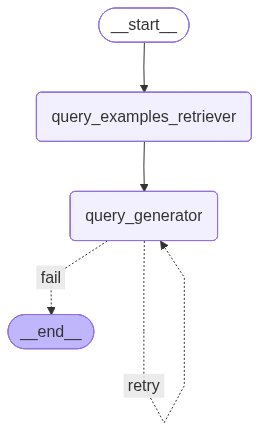

In [24]:
app = build_subgraph_query_generator(llm)
app

## EJEMPLOS

### CReo el grafo PADRE:

In [27]:
# Estado global del grafo padre
class GlobalState(TypedDict, total=False):
    context: str
    user_query: str
    dialect: NotRequired[str]
    language: NotRequired[str]
    sql_query: NotRequired[str]

# Construcción del grafo padre con el subgrafo como nodo
from langgraph.graph import StateGraph, START, END

def build_parent_graph(subgraph):
    g = StateGraph(State)
    g.add_node("nl2sql", subgraph)      # ← subgrafo compilado como nodo
    g.add_edge(START, "nl2sql")
    g.add_edge("nl2sql", END)
    return g.compile()

# Usar el subgrafo ya compilado (del paso 1)
parent_app = build_parent_graph(app)

global_initial: State = {
    "context": "Tablas:\n  customers(id, name, country)\n",
    "user_query": "Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen",
    "language": "Spanish"
}

app.invoke({
    "context": "Tablas:\n  customers(id, name, country)\n",
    "user_query": "Muéstrame los 10 productos más vendidos para el B2B en el último trimestre, excluyendo los Accesorios. Mes a mes indica cuántas unidades se vendieron, y muestra también a qué categoría y subcategoría pertenecen",
    "language": "Spanish"
})

#global_final = parent_app.invoke(global_initial, config={"recursion_limit": 50})
#print("FINAL SQL (padre):", global_final.get("sql_query"))


---QUERY EXAMPLES RETRIEVE TOOL---


InternalError: Error executing plan: Internal error: Error finding id